In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sns_toolbox.neurons import SpikingNeuron
from sns_toolbox.connections import SpikingSynapse
from sns_toolbox.networks import Network
from sns_toolbox.renderer import render

import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [2]:
# Takes spike data string, returns frequency of spikes
def getFreq(data, dt):
    loc = np.where(data == 1)[0]
    freq = []
    for i in range(len(loc)-1):
        freq.append(1 / ((loc[i+1] - loc[i]) * (dt * 0.001)))
    # The first element needs to be removed because this is inner spike, so more spikes than frequencies recorded
    loc = loc[1:] * dt
    return freq, loc

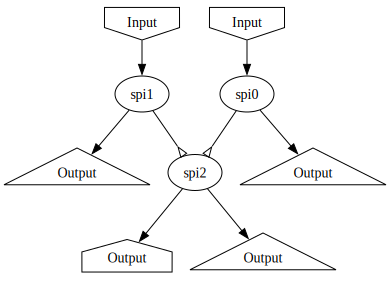

In [3]:
spi = SpikingNeuron()
spi2 = SpikingNeuron(
    threshold_initial_value=1.0
)
spiC = SpikingSynapse(
    max_conductance=1.0,
    reversal_potential=2.0
)

net = Network()
net.add_neuron(spi, name='spi0')
net.add_neuron(spi, name='spi1')
net.add_neuron(spi2, name='spi2')
net.add_connection(spiC, source='spi0', destination='spi2')
net.add_connection(spiC, source='spi1', destination='spi2')
net.add_input(dest='spi0')
net.add_input(dest='spi1')
net.add_output(source='spi2', spiking=False)
net.add_output(source='spi2', spiking=True)
net.add_output(source='spi1', spiking=True)
net.add_output(source='spi0', spiking=True)

render(net)

In [4]:
dt = 0.01
tmax = 20
t = np.arange(0, tmax, dt)

model = net.compile(dt=dt, backend='numpy', debug=False)

inputs = np.zeros([len(t), net.get_num_inputs()]) # + 3.5
inputs[:,1] += 3.5 # SPI1
inputs[:,0] += 2.5 # SPI0

data = np.zeros([len(t), net.get_num_outputs_actual()])
# spike_line = np.zeros([len(t), 1])
conductance_line = np.zeros([len(t), 1])

# noisy_threshold = (np.ones([1, len(t)]) + np.random.normal(0, 0.01, len(t))).flatten()

g_update = None
# Neuron order of addition to network: [spi0, spi1, spi2]
# And so the order of conductances needs to be: [spi0, spi1, spi2]
g_update = np.zeros([net.get_num_neurons(), net.get_num_neurons()]) + model.__dict__.get('g_max_spike')

for i in range(len(t)):
    data[i,:] = model(inputs[i,:], g_update=g_update, current_time=t[i])

    if i == 1:
        g_update[-1] = [3.5, 1.0, 0.0]
    if i == 2:
        g_update = None
    
    if i == 2000:
        g_update[-1] = [0.0, 10.0, 0.0]

    if i == 4000:
        g_update[-1] = [0.0, 2.0, 0.0]

    # spike_line[i] = model.__dict__.get('theta')[1]
    conductance_line[i] = model.__dict__.get('g_spike')[2][1]

data = data.transpose()

wins = 0
wine = len(t)

data_t = np.zeros([4, wine - wins])
t = t[wins:wine]
data_t[0] = data[0, wins:wine]
data_t[1] = data[1, wins:wine]
data_t[2] = data[2, wins:wine]
data_t[3] = data[3, wins:wine]

In [5]:
loc_pre = np.where(data[2, :] == 1)[0]
print(loc_pre)

[ 168  337  506  675  844 1013 1182 1351 1520 1689 1858]


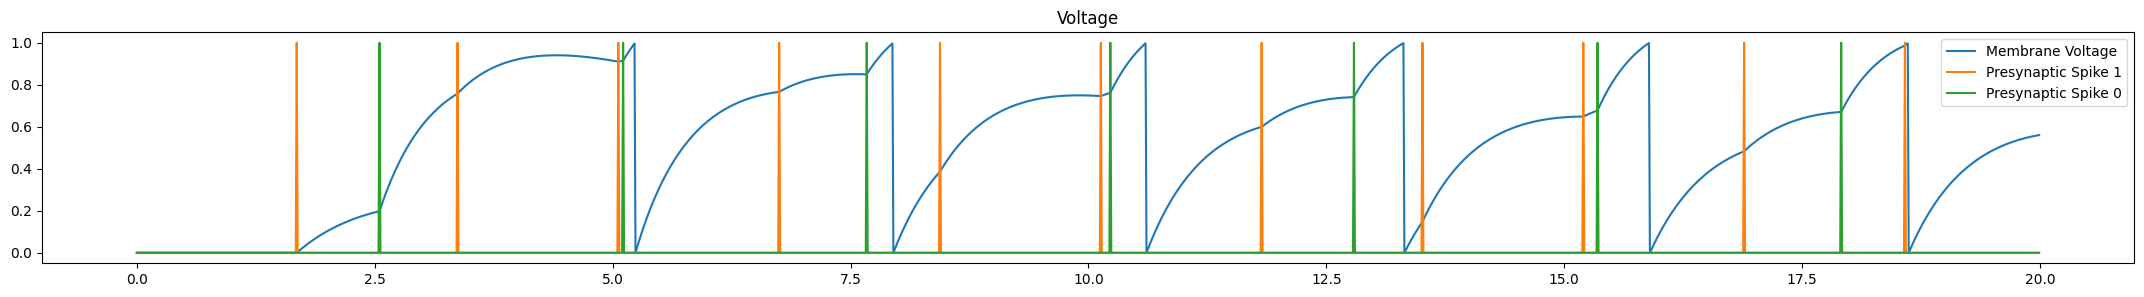

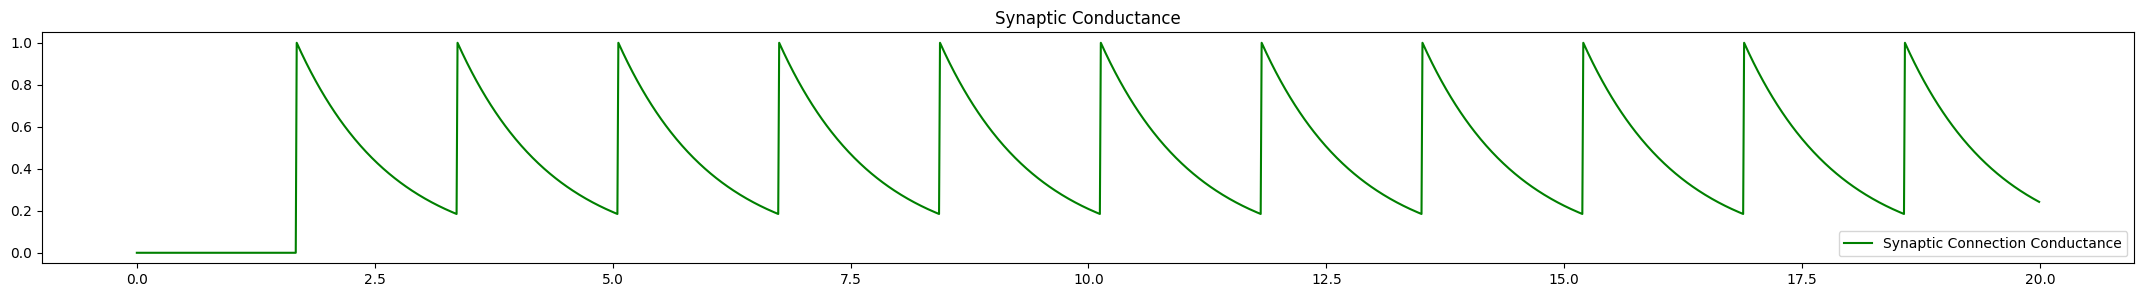

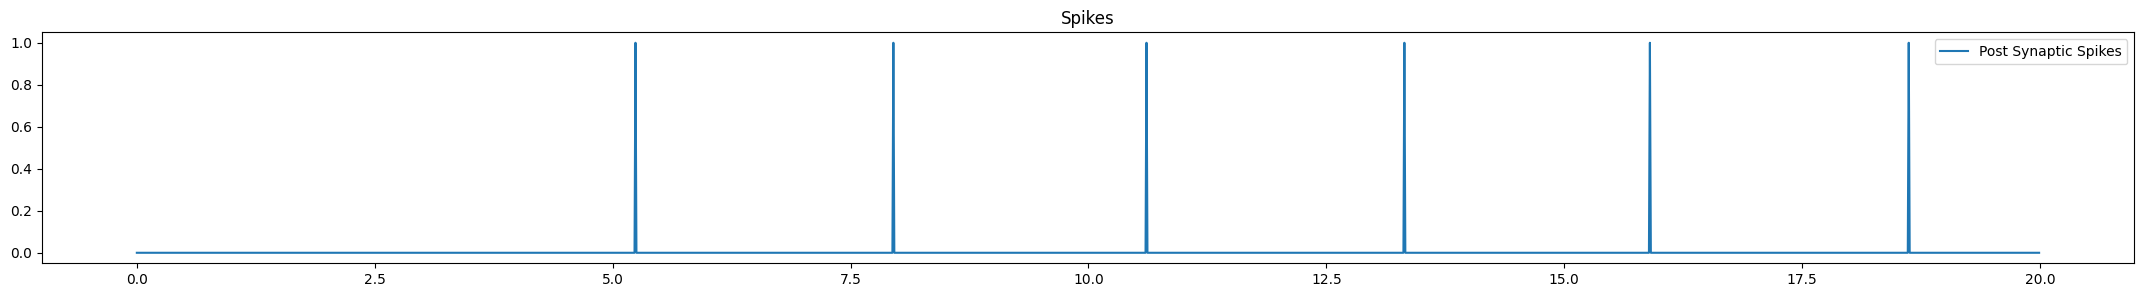

In [6]:
plt.figure(figsize=[27,3])
plt.plot(t, data_t[0], label='Membrane Voltage')
plt.plot(t, data_t[2], label='Presynaptic Spike 1')
plt.plot(t, data_t[3], label='Presynaptic Spike 0')
# plt.plot(t, spike_line, '-', color='red', label='Spike Threshold (Theta)')
plt.legend()
plt.title('Voltage')
plt.show()

plt.figure(figsize=[27,3])
plt.plot(t, conductance_line, label='Synaptic Connection Conductance', color='green')
plt.legend()
plt.title('Synaptic Conductance')
plt.show()

plt.figure(figsize=[27,3])
plt.plot(t, data_t[1], label='Post Synaptic Spikes')
plt.legend()
plt.title('Spikes')
plt.show()

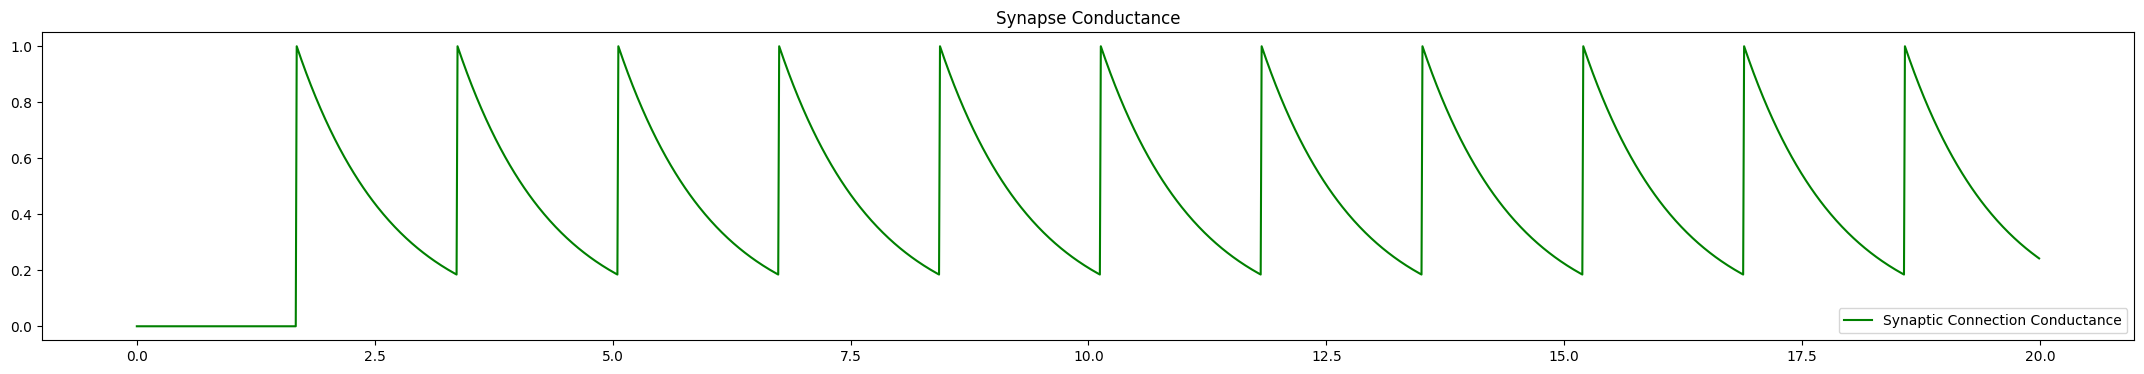

In [7]:
plt.figure(figsize=[27, 4])
plt.plot(t, conductance_line, label='Synaptic Connection Conductance', color='green')
plt.title('Synapse Conductance')
plt.legend()
plt.show()

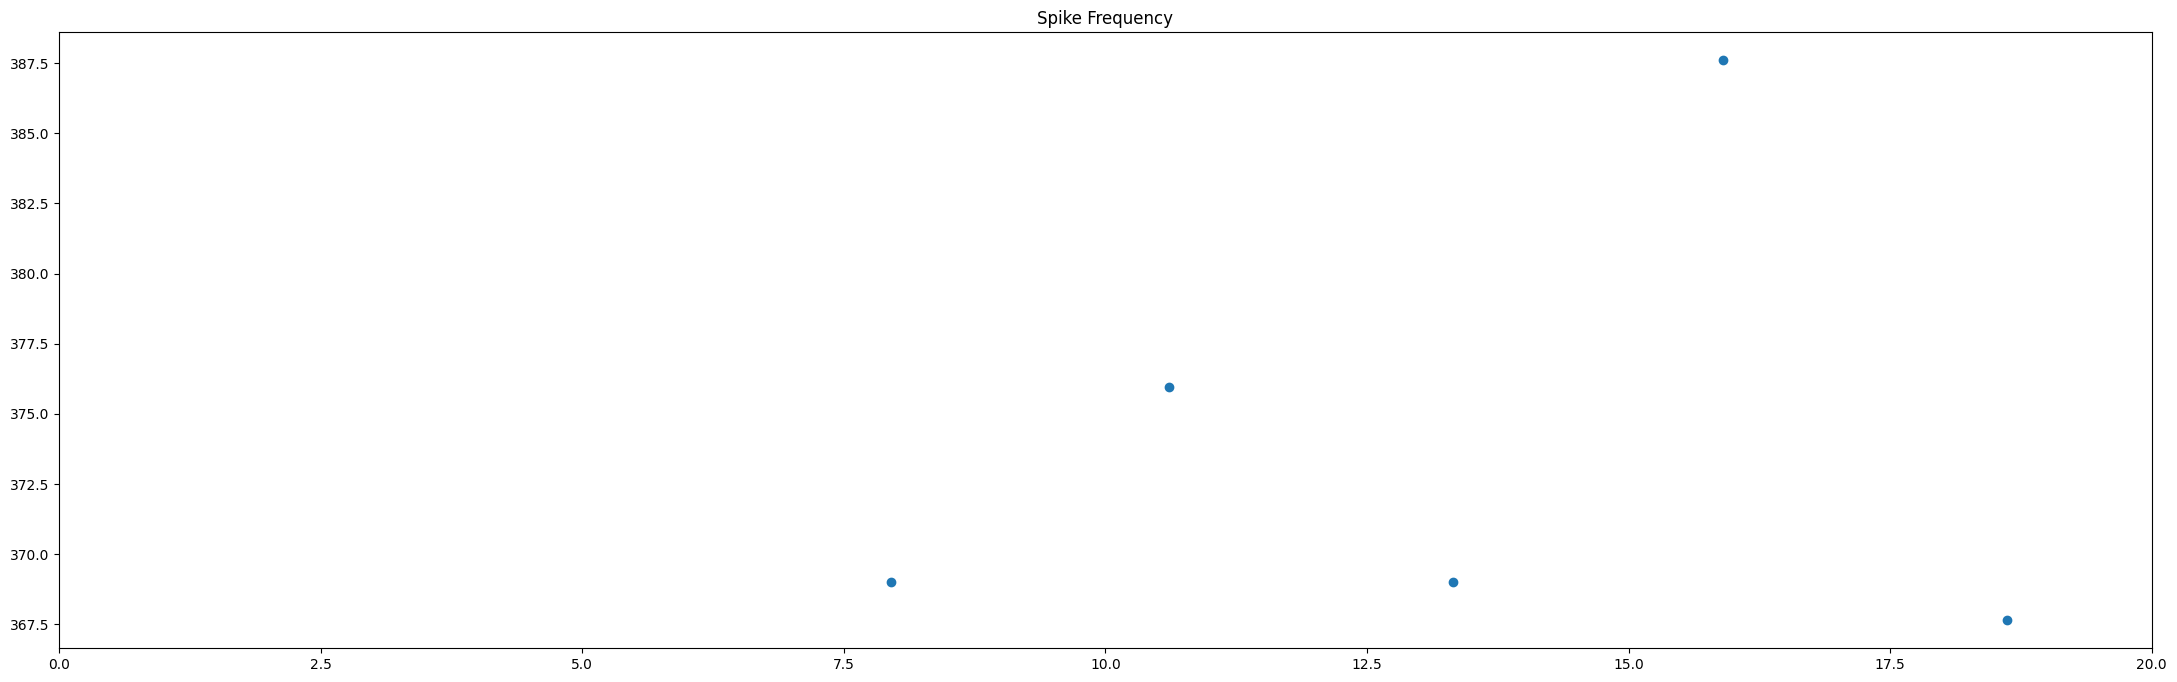

In [8]:
spike_freq, spike_loc = getFreq(data=data[1,:], dt=dt)

plt.figure(figsize=[27, 8])
plt.plot(spike_loc, spike_freq, 'o')
plt.xlim(0, tmax)
plt.title('Spike Frequency')
plt.show()

In [9]:
print('g_increment')
print(model.__dict__.get('g_increment'))
print('g_max_spike')
print(model.__dict__.get('g_max_spike'))

# model.__dict__

g_increment
[[0.  0.  0. ]
 [0.  0.  0. ]
 [3.5 1.  0. ]]
g_max_spike
[[0.  0.  0. ]
 [0.  0.  0. ]
 [3.5 1.  0. ]]


In [10]:
# a = np.ones([1, 5])
# print(a)

# b = [2, 3]
# print(b)

# # a[0][-1] = b[-1]

# # for i in range(len(b)):
# #     a[0][-(i+1)] = b[-(i+1)]

# a[0][-len(b):] = b

# print(a)

# a2 = model.__dict__.get('theta')
# print(a2)
# a2[(len(a2) - len(b)):] = b

# print(a2)



In [11]:
t = np.arange(0, 2000, 1)
act_freq = 100 # 100 steps of t. So with 2000 ms and steps of 1 ms, we would get a change every 100 ms 

def randActivation(t, act_freq):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])
    
    act = 0b00

    for i in range(len(t)):
        if i % act_freq == 0:
            if act & 0b10:
                i_IN1[i-act_freq:i] += 1
            if act & 0b10:
                i_IN2[i-act_freq:i] += 1
            if act & 0b01:
                i_IN3[i-act_freq:i] += 1
            if act & 0b01:
                i_IN4[i-act_freq:i] += 1
            
            act = randint(0, 3)
    
    return i_IN1, i_IN2, i_IN3, i_IN4

i_IN1, i_IN2, i_IN3, i_IN4 = randActivation(t, act_freq)

inputs_ = [i_IN1, i_IN2, i_IN3, i_IN4]
# print(inputs_)

# print(inputs)
# inputs[:, 0] = i_IN1
# print(inputs)

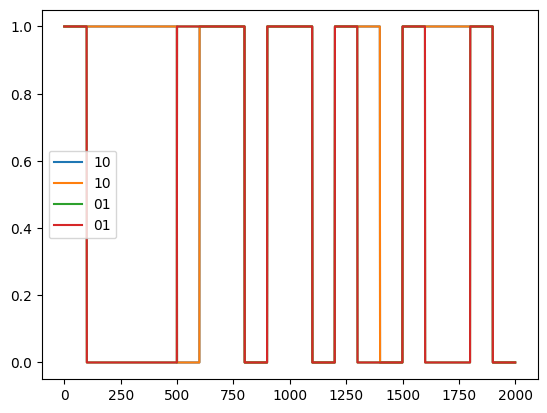

In [12]:
plt.figure()
plt.plot(t, i_IN1, label='10')
plt.plot(t, i_IN2, label='10')
plt.plot(t, i_IN3, label='01')
plt.plot(t, i_IN4, label='01')
plt.legend()
plt.show()

In [13]:
print(model.__dict__.get('spikes'))


[0. 0. 0.]
